In [12]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


In [13]:

def multiplyGauss (m1 , s1 , m2 , s2):
    s = 1 / (1/s1 + 1/s2)
    m = (m1/s1 + m2/s2) * s
    return m, s


def divideGauss (m1 , s1 , m2 , s2):
    m, s = multiplyGauss(m1 , s1 , m2 , -s2)
    return m, s

def truncGaussMM (a, b, m0 , s0):
    a_scaled , b_scaled = (a - m0) / np.sqrt(s0), (b - m0) / np.sqrt(s0)
    m = stats.truncnorm.mean(a_scaled , b_scaled , loc=m0 , scale=np.sqrt(s0))
    s = stats.truncnorm.var(a_scaled , b_scaled , loc=m0 , scale=np.sqrt(s0))
    return m, s

In [15]:
serie_A_data = pd.read_csv('Q5/SerieA.csv', delimiter=',')
print(serie_A_data.head())

   yyyy-mm-dd  HH:MM     team1     team2  score1  score2
0  2018-08-18  18:00    Chievo  Juventus       2       3
1  2018-08-18  20:30     Lazio    Napoli       1       2
2  2018-08-19  18:00    Torino      Roma       0       1
3  2018-08-19  20:30  Sassuolo     Inter       1       0
4  2018-08-19  20:30     Parma   Udinese       2       2


In [47]:
def get_posterior(initial_point, num_samples, y, beta_inv, m_s, sigma_s):

    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2]) 
    samples[0] = point
    A = np.array([[1, -1]])
    
    for i in range(num_samples):
        s1_sample, s2_sample = samples[i]
        if y==1:
            t = stats.truncnorm.rvs(a=0, b=np.inf, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))  # p(t|s1, s2, y)
        elif y==-1:
            t = stats.truncnorm.rvs(a=-np.inf, b=0, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))
            
        S = np.linalg.inv(np.linalg.inv(sigma_s) + (beta_inv)**(-1) * (A.T @ A))
        m = S @ (np.linalg.inv(sigma_s) @ m_s + beta_inv**(-1) * A.T * t)

        point = np.random.multivariate_normal(m.ravel(), S)
        samples[i+1] = point

    return m[0][0], m[1][0], S[0,0], S[1,1], point

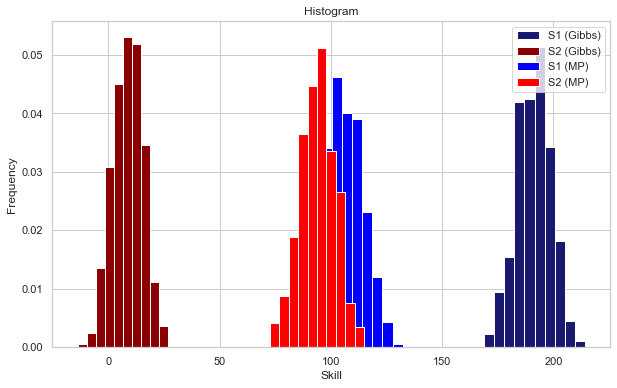

In [50]:
num_samples= 10000   # Nr of Gibbs samples

# Prior parameters
mu1 = 100
sigma1 = 100

mu2 = 100
sigma2 = 100

beta_inv = 1
y = 1    # If y = 1, player 1 wins. y = -1, player 2 wins

# Initial samples for Gibbs
s1 = np.random.normal(mu1, np.sqrt(sigma1))
s2 = np.random.normal(mu2, np.sqrt(sigma2))

mu1_gibbs, mu2_gibbs, sigma1_gibbs, sigma2_gibbs, _ = get_posterior(initial_point = [s1, s2],
                                                            num_samples = num_samples,
                                                            y = y,
                                                            beta_inv = beta_inv,
                                                            m_s = np.array([[mu1], [mu2]]),
                                                            sigma_s = np.array([[sigma1, 0], [0, sigma2]]))

mt, st = truncGaussMM(0, np.inf, mu1-mu2 , beta_inv + sigma1 + sigma2) if y==1 else  truncGaussMM(-np.inf, 0, mu1-mu2 , beta_inv + sigma1 + sigma2)
    
m6, s6 = divideGauss(mt , st , mu1-mu2 , beta_inv + sigma1 + sigma2)

m71, m72 = m6 + mu2, -m6 + mu1
s71, s72 = beta_inv + sigma2 + s6, beta_inv + sigma1 + s6

mu1_MP, sigma1_MP = multiplyGauss(mu1, sigma1, m71, s71)
mu2_MP, sigma2_MP = multiplyGauss(mu2, sigma2, m72, s72)

num_samples_hist = 400
S1_gibbs_samples = np.random.normal(mu1_gibbs, np.sqrt(sigma1_gibbs), num_samples_hist)
S2_gibbs_samples = np.random.normal(mu2_gibbs, np.sqrt(sigma2_gibbs), num_samples_hist)

S1_MP_samples = np.random.normal(mu1_MP, np.sqrt(sigma1_MP), num_samples_hist)
S2_MP_samples = np.random.normal(mu2_MP, np.sqrt(sigma2_MP), num_samples_hist)


plt.figure(figsize=(10, 6))
plt.hist(S1_gibbs_samples, density=True, label='S1 (Gibbs)', color = 'midnightblue')
plt.hist(S2_gibbs_samples, density=True, label='S2 (Gibbs)', color = 'darkred')
plt.hist(S1_MP_samples, density=True, label='S1 (MP)', color = 'blue')
plt.hist(S2_MP_samples, density=True, label='S2 (MP)', color = 'red')


plt.xlabel('Skill')
plt.ylabel('Frequency')
plt.title(f'Histogram')
plt.legend()
plt.show()
